In [389]:
# ---------------- Libraries-----------------
import numpy as np 
import pandas as pd 
# ---------------- Plotting------------------
import seaborn as snb
import matplotlib.pyplot as plt
%matplotlib inline
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # forces tf to run on cpu 
# ---------------- Sklearn libraries---------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
le = preprocessing.LabelEncoder()
# ---------------- Keras---------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
# ----------------Tensor-flow support--------
import tensorflow_addons as tfa
# -----------------Warnings------------------
#removing cuda warnings for gpu
import warnings
warnings.filterwarnings('ignore')

## Read Train and Test Data

In [390]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

train_df = train_df.drop('Segmentation' , axis=1)
train_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6


In [391]:
train_df.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
dtype: int64

## Data Preprocessing 

### Replacing empty values NaN with Mode in Train And Test dataset

In [392]:
# replaces NaN values in numerical columns with the mode of each respective column.
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
col_num = train_df.select_dtypes(include=numerics)

for col in col_num:
    train_df[col].replace([np.nan], train_df[col].mode()[0], inplace=True)

In [393]:
#replaces NaN values in categorical columns with the string 'None'.
categorical = ['object']
cat_columns = train_df.select_dtypes(include=categorical)

for col in cat_columns:
    train_df[col].replace([np.nan], 'None', inplace=True)


In [394]:
# replaces NaN values in numerical columns with the mode of each respective column.
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
col_num = test_df.select_dtypes(include=numerics)

for col in col_num:
    test_df[col].replace([np.nan], test_df[col].mode()[0], inplace=True)

In [395]:
#replaces NaN values in categorical columns with the string 'None'.
categorical = ['object']
cat_columns = test_df.select_dtypes(include=categorical)

for col in cat_columns:
    test_df[col].replace([np.nan], 'None', inplace=True)


In [396]:
train_df.isnull().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
dtype: int64

In [397]:
test_df.isnull().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
dtype: int64

In [398]:
label_list = set(train_df['Var_1'])
label_list

{'Cat_1', 'Cat_2', 'Cat_3', 'Cat_4', 'Cat_5', 'Cat_6', 'Cat_7', 'None'}

In [399]:
train_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
1,462643,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6
4,462669,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6


### Preprocessing Train Dataset

In [400]:
def replacing_classes(row: 'object'):
    if row != 'Cat_4' and row != 'Cat_6':
        return 'Other'
    else:
        return row

train=True, 
only_label=False

try:
    # Dropping specified columns
    if train:
        print('dropping columns...')
        train_df.drop(columns=['ID', 'Age'], inplace=True)
    if not train:
        print('dropping ID column')
        train_df.drop(columns=['ID', 'Var_1', 'Age'], inplace=True)

    # Replacing numerical NaNs with mode
    print('replacing numerical NaNs with mode...')
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    col_num = train_df.select_dtypes(include=numerics)
    for col in col_num:
        train_df[col].replace([np.nan], train_df[col].mode()[0], inplace=True)

    # Replacing categorical NaNs with 'None' string
    print('replacing categorical NaNs with None string...')
    categorical = ['object']
    cat_columns = train_df.select_dtypes(include=categorical)
    for col in cat_columns:
        train_df[col].replace([np.nan], 'None', inplace=True)

    # Changing anything other than 'Cat_6' and 'Cat_4' to 'Other'
    if train:
        print('changing anything other than Cat_6 and Cat_4 to Other...')
        # train_df['Var_1'] = train_df['Var_1'].apply(replacing_classes)
        train_df['Var_1'].replace(['Cat_3', 'Cat_2', 'Cat_7', 'Cat_1', 'Cat_5'], ["Other","Other","Other","Other","Other"], inplace=True)
        print(train_df['Var_1'].value_counts())

    # Label encoding categorical data
    print('label encoding categorical data...')
    label_encoder = preprocessing.LabelEncoder()
    columns_to_encode = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
    for column in columns_to_encode:
        train_df[column] = label_encoder.fit_transform(train_df[column])

    print('\033[1m' + 'SUCCESSFULLY PERFORMED PREPROCESSING' + '\033[0m')
except Exception as e:
    print('error occurred in pre-processing')
    print(e)
    # Return False or handle the error as needed


dropping columns...
replacing numerical NaNs with mode...
replacing categorical NaNs with None string...
changing anything other than Cat_6 and Cat_4 to Other...
Var_1
Cat_6    5238
Other    1665
Cat_4    1089
None       76
Name: count, dtype: int64
label encoding categorical data...
SUCCESSFULLY PERFORMED PREPROCESSING


### 'ID' and 'Age' columns are dropped as they do not contribute to classification

### Also 'Segmentation' column is dropped as it in the train dataset but not in test dataset

## Preprocessing for Test dataset

In [401]:
try:
    # Dropping specified columns
    if train:
        print('dropping columns...')
        test_df.drop(columns=['ID', 'Age'], inplace=True)
    if not train:
        print('dropping ID column')
        test_df.drop(columns=['ID', 'Var_1', 'Age'], inplace=True)

    # Replacing numerical NaNs with mode
    print('replacing numerical NaNs with mode...')
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    col_num = test_df.select_dtypes(include=numerics)
    for col in col_num:
        test_df[col].replace([np.nan], test_df[col].mode()[0], inplace=True)

    # Replacing categorical NaNs with 'None' string
    print('replacing categorical NaNs with None string...')
    categorical = ['object']
    cat_columns = test_df.select_dtypes(include=categorical)
    for col in cat_columns:
        test_df[col].replace([np.nan], 'None', inplace=True)

    # Changing anything other than 'Cat_6' and 'Cat_4' to 'Other'
    if train:
        print('changing anything other than Cat_6 and Cat_4 to Other...')
        # train_df['Var_1'] = train_df['Var_1'].apply(replacing_classes)
        test_df['Var_1'].replace(['Cat_3', 'Cat_2', 'Cat_7', 'Cat_1', 'Cat_5'], ["Other","Other","Other","Other","Other"], inplace=True)
        print(test_df['Var_1'].value_counts())

    # Label encoding categorical data
    print('label encoding categorical data...')
    label_encoder = preprocessing.LabelEncoder()
    columns_to_encode = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
    for column in columns_to_encode:
        test_df[column] = label_encoder.fit_transform(test_df[column])

    print('\033[1m' + 'SUCCESSFULLY PERFORMED PREPROCESSING' + '\033[0m')
except Exception as e:
    print('error occurred in pre-processing')
    print(e)
    # Return False or handle the error as needed

dropping columns...
replacing numerical NaNs with mode...
replacing categorical NaNs with None string...
changing anything other than Cat_6 and Cat_4 to Other...
Var_1
Cat_6    1672
Other     537
Cat_4     386
None       32
Name: count, dtype: int64
label encoding categorical data...
SUCCESSFULLY PERFORMED PREPROCESSING


In [402]:
label_list = set(test_df['Var_1'])

labels = list(label_list)

In [403]:
labels

[0, 1, 2, 3]

In [404]:
train_df.head()

,Gender,Ever_Married,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,1,0,0,5,1.0,2,4.0,0
1,0,2,2,2,1.0,0,3.0,0
2,0,2,2,2,1.0,2,1.0,1
3,1,2,2,7,0.0,1,2.0,1
4,0,2,2,3,1.0,1,6.0,1


In [405]:
test_df.head()

,Gender,Ever_Married,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,0,2,2,2,0.0,2,1.0,1
1,1,2,2,5,8.0,0,4.0,1
2,0,2,0,9,0.0,2,1.0,1
3,1,2,0,4,11.0,1,2.0,1
4,0,0,0,8,1.0,2,4.0,1


### Assigning data to X and y for training and validation  

In [406]:
# Define your features (X) and target (y)
X = train_df.drop(columns=['Var_1'])
y = train_df['Var_1']

In [407]:
X.head()

,Gender,Ever_Married,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,1,0,0,5,1.0,2,4.0
1,0,2,2,2,1.0,0,3.0
2,0,2,2,2,1.0,2,1.0
3,1,2,2,7,0.0,1,2.0
4,0,2,2,3,1.0,1,6.0


In [408]:
y.head()

0    0
1    0
2    1
3    1
4    1
Name: Var_1, dtype: int32

## Splitting training DataSet in training and validation 

### Shuffling data before training 

In [409]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1, stratify=y , shuffle=True)

In [410]:
y_train

3108    0
3881    1
5163    1
2013    3
6074    1
       ..
1149    1
4633    3
5873    2
4877    3
3182    1
Name: Var_1, Length: 6051, dtype: int32

In [411]:
y_train.value_counts()

Var_1
1    3928
3    1249
0     817
2      57
Name: count, dtype: int64

## Building the neural network

In [412]:
# Define the neural network architecture
model = Sequential()
model.add(Dense(512, input_shape=(X_train.shape[1],)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128))
# Dropout for regularization
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(len(y_train.unique()), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[tfa.metrics.F1Score(average='micro', num_classes=len(y_train.unique())), 'accuracy'])
print(model.summary())

# Convert data to numpy arrays
X_train_array = X_train.values
y_train_array = y_train.values
X_val_array = X_val.values
y_val_array = y_val.values

# Callback to stop training if reverse learning happens
# Patience is set to 25, stop won't happen before 50 epochs
callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=50)

# Train the model
history = model.fit(X_train_array, y_train_array, epochs=300, verbose=1, validation_data=(X_train_array, y_train_array))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 512)               4096      
                                                                 
 dense_78 (Dense)            (None, 256)               131328    
                                                                 
 dense_79 (Dense)            (None, 128)               32896     
                                                                 
 dropout_33 (Dropout)        (None, 128)               0         
                                                                 
 dense_80 (Dense)            (None, 64)                8256      
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 dense_81 (Dense)            (None, 16)              

## Stopping logic from keras library

In [413]:
# # Evaluate the model on the test set
test_loss, test_f1, test_acc = model.evaluate(X_val_array, y_val_array)
# print(f'Test loss: {test_loss}, Test F1 Score: {test_f1}, Test accuracy: {test_acc}')

# Callback to stop training if reverse learning happens and monitor F1-score on validation data
callbacks = [EarlyStopping(monitor='val_f1_score', mode='max', patience=75, restore_best_weights=True)]

# Train the model
history = model.fit(X_train_array, y_train_array, epochs=150, verbose=1, 
                    validation_data=(X_val_array, y_val_array), callbacks=callbacks)

print(f'Test loss: {test_loss}, Test F1 Score: {test_f1}, Test accuracy: {test_acc}')

64/64 [==============================] - 0s 2ms/step - loss: 0.8826 - f1_score: 0.4187 - accuracy: 0.6564
Epoch 1/150
190/190 [==============================] - 1s 5ms/step - loss: 0.8583 - f1_score: 0.4187 - accuracy: 0.6569 - val_loss: 0.8877 - val_f1_score: 0.4187 - val_accuracy: 0.6515
Epoch 2/150
190/190 [==============================] - 1s 5ms/step - loss: 0.8555 - f1_score: 0.4187 - accuracy: 0.6592 - val_loss: 0.8817 - val_f1_score: 0.4187 - val_accuracy: 0.6544
Epoch 3/150
190/190 [==============================] - 1s 5ms/step - loss: 0.8585 - f1_score: 0.4187 - accuracy: 0.6568 - val_loss: 0.8866 - val_f1_score: 0.4187 - val_accuracy: 0.6539
Epoch 4/150
190/190 [==============================] - 1s 5ms/step - loss: 0.8589 - f1_score: 0.4187 - accuracy: 0.6607 - val_loss: 0.8852 - val_f1_score: 0.4187 - val_accuracy: 0.6539
Epoch 5/150
190/190 [==============================] - 1s 5ms/step - loss: 0.8574 - f1_score: 0.4187 - accuracy: 0.6586 - val_loss: 0.8826 - val_f1_score:

## Use test data to calculate the appropriate classification metrics

In [414]:
# create X_test and y_test
X_test = test_df.drop('Var_1', axis=1)
y_test = test_df['Var_1']

## Generate the loss and f1-score curve for training and validation set

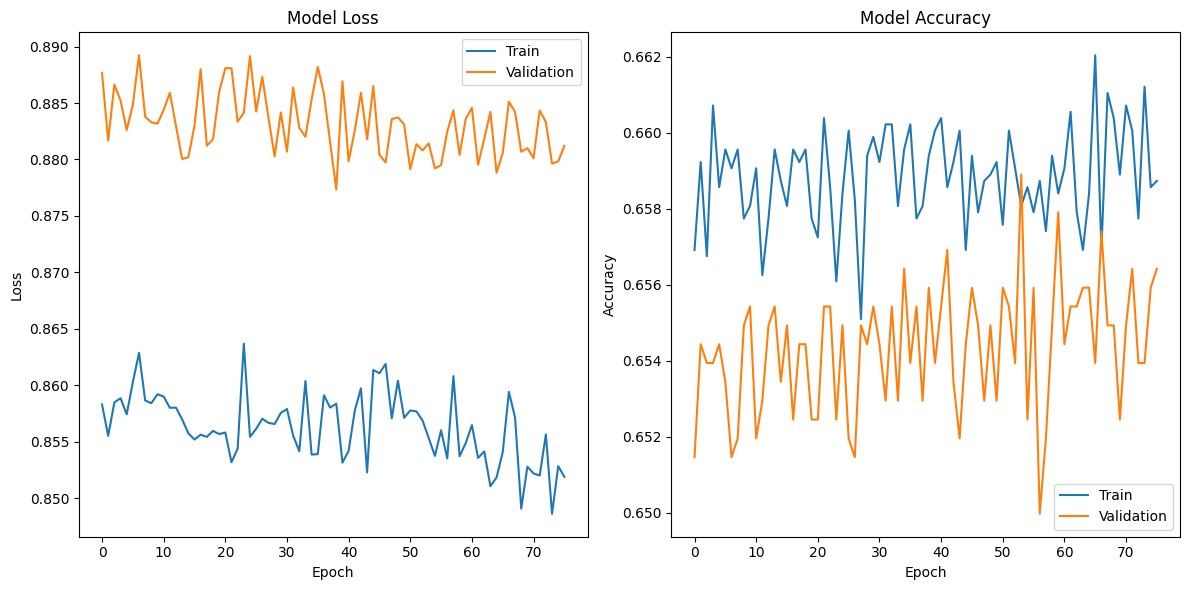

In [415]:
# Plotting the Loss curves
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plotting the F1-Score curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

In [416]:
# make prediction on test data
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred

83/83 [==============================] - 0s 2ms/step


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [417]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.05      0.10       386
           1       0.64      1.00      0.78      1672
           2       0.00      0.00      0.00        32
           3       0.00      0.00      0.00       537

    accuracy                           0.64      2627
   macro avg       0.37      0.26      0.22      2627
weighted avg       0.53      0.64      0.51      2627



Accuracy: Overall accuracy is 0.64, representing the proportion of correctly classified instances across all classes. However, accuracy might be misleading, especially in imbalanced datasets.

Precision: Precision is high for Class 1 (1.00), indicating that when the model predicts Class 1, it is very accurate.
For other classes (0, 2, 3), precision is low, suggesting a higher rate of false positives.

Recall (Sensitivity): Recall is high for Class 1 (1.00), meaning the model effectively captures true positives for Class 1.
Recall is very low for Classes 0, 2, and 3, indicating that the model misses a significant number of actual positives for these classes.

F1-Score:The F1-Score is the harmonic mean of precision and recall. It's high for Class 1 (0.78), reflecting a good balance between precision and recall.
F1-Score is low for Classes 0, 2, and 3, emphasizing the imbalance between precision and recall for these classes.

Looking at the epoch-wise performance during training:

The loss is decreasing, indicating that the model is learning to minimize the error between predicted and true labels.
F1-Score and accuracy metrics are improving, suggesting the model's ability to correctly classify instances.

## Generate a ROC-AUC curve 

In [418]:
def calculate_tpr_fpr(y_real, y_pred):

# Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    tpr =  TP/(TP + FN)
    fpr = 1 - TN/(TN+FP)

    return tpr, fpr

In [419]:
def get_all_roc_coordinates(y_real, y_proba):
# Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.

    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [420]:
# Reference: https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).

    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()

    if scatter:
        snb.scatterplot(x = fpr, y = tpr, ax = ax)
    snb.lineplot(x = fpr, y = tpr, ax = ax)
    snb.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [421]:
X_test = pd.DataFrame(X_test)
#y_test = pd.DataFrame(y_test)
X_test.shape, y_test.shape

((2627, 7), (2627,))

In [422]:
classes = np.unique(y_pred, return_counts=False)
print(classes)

[0 1]


0 0
1 1


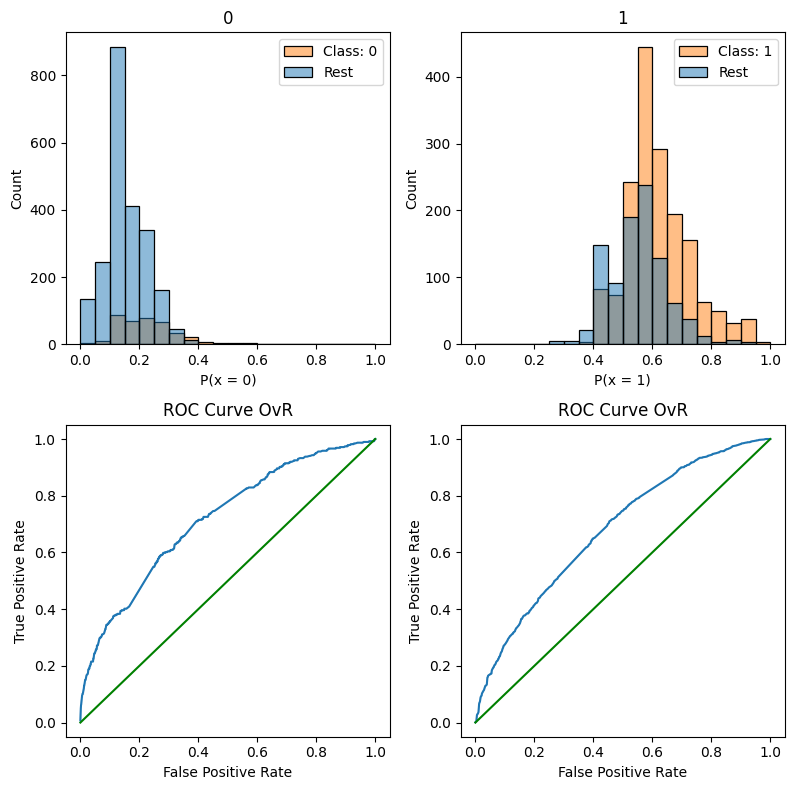

In [423]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}

for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    l= labels[i]
    print(l,c)

    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_pred_prob[:, i]
    df_aux = df_aux.reset_index(drop = True)

    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 3, i+1)
    snb.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(l)
    ax.legend([f"Class: {l}", "Rest"])
    ax.set_xlabel(f"P(x = {l})")

    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")

    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

plt.tight_layout()

ROC curves are not very promising in this mode. You can see that for most of the classes, ROC curve is below the 0.5 probability which means that model is performing worse than a coin toss. This is most probably because of a small number of data that we have. For neural network, minimum of a few million data-sets are required.

In [424]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(labels[k], f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")

0 0 ROC AUC OvR: 0.7170
1 1 ROC AUC OvR: 0.6803
average ROC AUC OvR: 0.6987


## Oversampling 

### Used oversampling from imblearn to balance data sets

Realising now the usage of functions would be more effective and would remove redundancy of code at many instances . But due to time constraints could implement . My apologies

In [425]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(train_df.drop('Var_1', axis=1), train_df['Var_1'])
train_df['Var_1'].value_counts(), y_resampled.value_counts()

(Var_1
 1    5238
 3    1665
 0    1089
 2      76
 Name: count, dtype: int64,
 Var_1
 0    5238
 1    5238
 3    5238
 2    5238
 Name: count, dtype: int64)

In [426]:
#Divide train into training and validation with shuffle
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=3, shuffle=True)
X_train.shape

(14666, 7)

In [432]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[tfa.metrics.F1Score(average='micro', num_classes=len(y_train.unique())), 'accuracy'])
print(model.summary())

# Convert data to numpy arrays
X_train_array = X_train.values
y_train_array = y_train.values
X_val_array = X_val.values
y_val_array = y_val.values

# Callback to stop training if reverse learning happens
# Patience is set to 25, stop won't happen before 150 epochs
callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=25)

# Train the model
history = model.fit(X_train_array, y_train_array, epochs=75, verbose=1, validation_data=(X_train_array, y_train_array))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 512)               4096      
                                                                 
 dense_78 (Dense)            (None, 256)               131328    
                                                                 
 dense_79 (Dense)            (None, 128)               32896     
                                                                 
 dropout_33 (Dropout)        (None, 128)               0         
                                                                 
 dense_80 (Dense)            (None, 64)                8256      
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 dense_81 (Dense)            (None, 16)              

None
Epoch 1/75
459/459 [==============================] - 4s 6ms/step - loss: 1.0529 - f1_score: 0.4287 - accuracy: 0.5074 - val_loss: 1.0316 - val_f1_score: 0.4287 - val_accuracy: 0.5159
Epoch 2/75
459/459 [==============================] - 3s 6ms/step - loss: 1.0736 - f1_score: 0.4287 - accuracy: 0.4943 - val_loss: 1.0692 - val_f1_score: 0.4287 - val_accuracy: 0.5001
Epoch 3/75
459/459 [==============================] - 3s 6ms/step - loss: 1.1052 - f1_score: 0.4287 - accuracy: 0.4836 - val_loss: 1.0491 - val_f1_score: 0.4287 - val_accuracy: 0.5127
Epoch 4/75
459/459 [==============================] - 3s 6ms/step - loss: 1.0646 - f1_score: 0.4287 - accuracy: 0.4981 - val_loss: 1.0355 - val_f1_score: 0.4287 - val_accuracy: 0.5095
Epoch 5/75
459/459 [==============================] - 3s 6ms/step - loss: 1.0742 - f1_score: 0.4287 - accuracy: 0.4937 - val_loss: 1.0670 - val_f1_score: 0.4287 - val_accuracy: 0.4943
Epoch 6/75
459/459 [==============================] - 3s 6ms/step - loss: 1

In [428]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, batch_size=128, verbose=1, callbacks=[callbacks])

Epoch 1/25
115/115 [==============================] - 2s 9ms/step - loss: 1.0610 - f1_score: 0.4287 - accuracy: 0.5037 - val_loss: 1.0295 - val_f1_score: 0.4282 - val_accuracy: 0.5196
Epoch 2/25
115/115 [==============================] - 1s 7ms/step - loss: 1.0467 - f1_score: 0.4287 - accuracy: 0.5059 - val_loss: 1.0231 - val_f1_score: 0.4282 - val_accuracy: 0.5213
Epoch 3/25
115/115 [==============================] - 1s 7ms/step - loss: 1.0347 - f1_score: 0.4287 - accuracy: 0.5137 - val_loss: 1.0119 - val_f1_score: 0.4282 - val_accuracy: 0.5232
Epoch 4/25
115/115 [==============================] - 1s 7ms/step - loss: 1.0415 - f1_score: 0.4287 - accuracy: 0.5046 - val_loss: 1.0229 - val_f1_score: 0.4282 - val_accuracy: 0.5202
Epoch 5/25
115/115 [==============================] - 1s 7ms/step - loss: 1.0288 - f1_score: 0.4287 - accuracy: 0.5145 - val_loss: 1.0137 - val_f1_score: 0.4282 - val_accuracy: 0.5227
Epoch 6/25
115/115 [==============================] - 1s 7ms/step - loss: 1.0369

In [433]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(np.unique(y_pred,return_counts=True))

83/83 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.27      0.39      0.32       386
           1       0.67      0.53      0.60      1672
           2       0.03      0.59      0.05        32
           3       0.00      0.00      0.00       537

    accuracy                           0.40      2627
   macro avg       0.24      0.38      0.24      2627
weighted avg       0.47      0.40      0.43      2627

[[151 158  76   1]
 [295 892 485   0]
 [  1  12  19   0]
 [110 261 166   0]]
(array([0, 1, 2, 3], dtype=int64), array([ 557, 1323,  746,    1], dtype=int64))


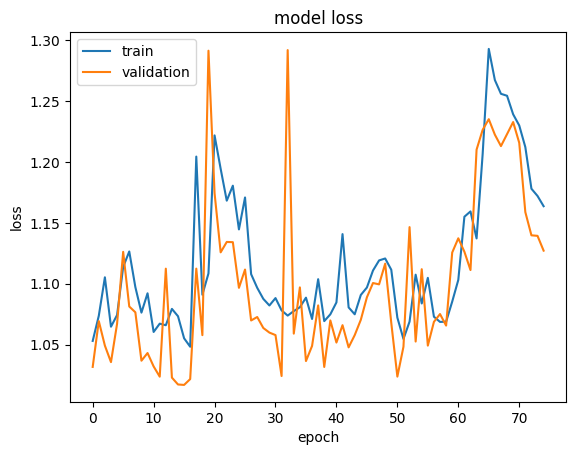

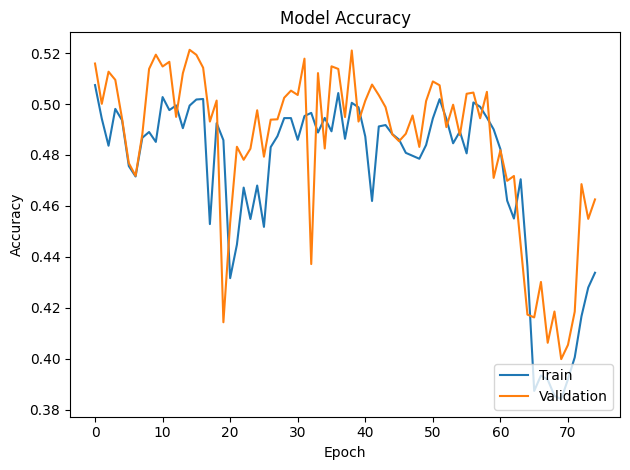

In [434]:
# plot the loss and f1-score curve for training and validation set.

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

Model is definitely learning in training set. you can see that loss is decreasing and f1_score is increasing. However Because of small number of data (although it was shuffled and stratified) model doesn't reach its best form. The early stopage was applied and the model stopped after 25 epoch of 75 total epochs.

0 0
1 1
2 2
3 3


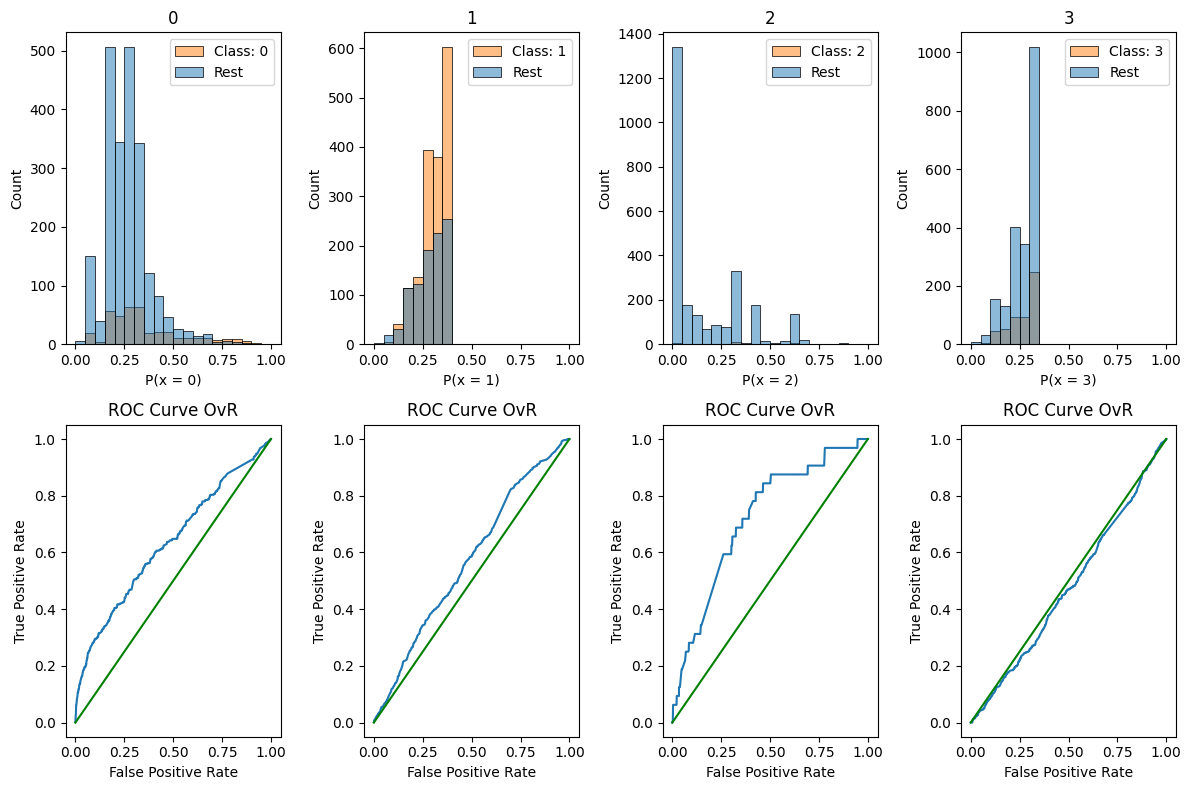

In [436]:
X_test = pd.DataFrame(X_test)

classes = np.unique(y_pred, return_counts=False)

# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize=(12, 8))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}

# Adjust the subplot layout to accommodate more classes if needed
num_subplots = len(classes) * 2
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.4, wspace=0.4)

for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    l = labels[i]
    print(l, c)

    # Prepares an auxiliary dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_pred_prob[:, i]
    df_aux = df_aux.reset_index(drop=True)

    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, num_subplots // 2, i+1)
    snb.histplot(x="prob", data=df_aux, hue='class', color='b', ax=ax, bins=bins)
    ax.set_title(l)
    ax.legend([f"Class: {l}", "Rest"])
    ax.set_xlabel(f"P(x = {l})")

    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, num_subplots // 2, i + 1 + len(classes))
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter=False, ax=ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")

    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

plt.tight_layout()

Precision: Precision is the ratio of true positive predictions to the total predicted positives.
Precision for each class is low, especially for classes 0, 2, and 3. This indicates a high rate of false positives for these classes.

Recall: Recall (Sensitivity or True Positive Rate) is the ratio of true positive predictions to the total actual positives.
Recall is relatively low for class 0 and class 3, suggesting that the model has difficulty correctly identifying instances of these classes.

F1-Score: F1-Score is the harmonic mean of precision and recall. It provides a balance between precision and recall.
The F1-Score is low for most classes, indicating an overall imbalance between precision and recall.

Support: Support is the number of actual occurrences of the class in the specified dataset.
Class 1 has the highest support, which is expected given its larger number of instances in the dataset.

Accuracy:Accuracy is the ratio of correctly predicted instances to the total instances.
The overall accuracy is 0.40, which means the model is correctly predicting the class label for 40% of instances.
Accuracy has decreased substainially to 40 percent from 60 percent due to oversampling. 

The model struggles with classes 0, 2, and 3, as indicated by low precision, recall, and F1-Score for these classes.
Further analysis and potentially model tuning are needed to address the class imbalance and improve the model's ability to correctly predict minority classes.
Consider exploring techniques like hyperparameter tuning, feature engineering, and different sampling strategies to enhance the model's performance, especially for the underrepresented classes.